In [2]:
from typing import List, Dict
import warnings
warnings.filterwarnings("ignore", message="A parameter name that contains")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn import metrics
from imblearn.over_sampling import SMOTE
import textstat
import joblib

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Elgabrey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Elgabrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Elgabrey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Elgabrey\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Elgabrey\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
def load_and_prepare_data(path: str) -> pd.DataFrame:
    """
    Load dataset and rename columns.

    Args:
        path (str): File path to CSV dataset.

    Returns:
        pd.DataFrame: Prepared dataframe with columns ['text', 'label'].
    """
    data = pd.read_csv(path)
    data.rename(columns={'sentence': 'text', 'emotion': 'label'}, inplace=True)
    return data

data = load_and_prepare_data(r"D:\Grad_Proj\project\combined_emotion.csv")
data

,text,label
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sad
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sad
4,i am a kindergarten teacher and i am thoroughl...,fear
...,...,...
422741,i begun to feel distressed for you,fear
422742,i left feeling annoyed and angry thinking that...,anger
422743,i were to ever get married i d have everything...,joy
422744,i feel reluctant in applying there because i w...,fear


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422746 entries, 0 to 422745
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    422746 non-null  object
 1   label   422746 non-null  object
dtypes: object(2)
memory usage: 6.5+ MB


In [6]:
data['No_of_Chars'] = data['text'].apply(len)
data['No_of_Words'] = data.apply(lambda row: nltk.word_tokenize(row['text']), axis= 1).apply(len)
data['No_of_Sents'] = data.apply(lambda row: nltk.sent_tokenize(row['text']), axis= 1).apply(len)

data.describe()

,No_of_Chars,No_of_Words,No_of_Sents
count,422746.000000,422746.000000,422746.0
mean,97.033980,19.220179,1.0
std,56.198156,11.057121,0.0
min,2.000000,1.000000,1.0
25%,54.000000,11.000000,1.0
50%,86.000000,17.000000,1.0
75%,128.000000,25.000000,1.0
max,830.000000,178.000000,1.0


In [7]:
def encode_labels(df: pd.DataFrame, col: str) -> (pd.DataFrame, LabelEncoder):
    """
    Encode categorical labels to integers.

    Args:
        df (pd.DataFrame): Input dataframe.
        col (str): Column name of labels.

    Returns:
        tuple: Dataframe with encoded labels, fitted LabelEncoder.
    """
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    return df, le

data, le = encode_labels(data, 'label')


C:\Users\Elgabrey\AppData\Local\Temp\ipykernel_23504\575512067.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fg = sns.countplot(x= data['label'], palette= cols_color)


Text(0, 0.5, 'count of classes')

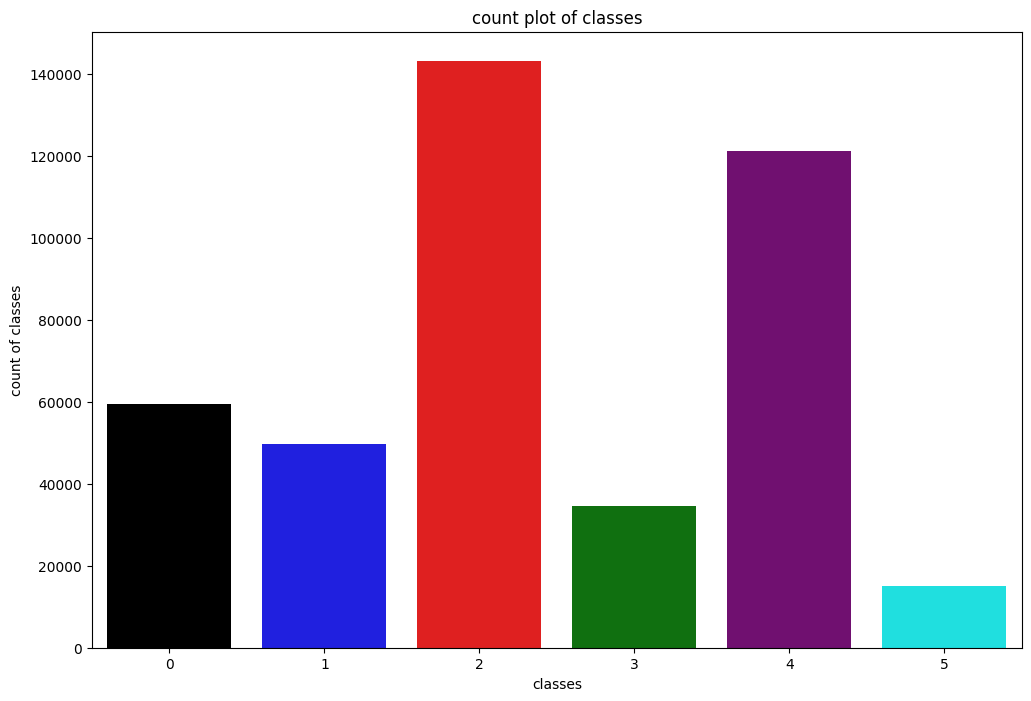

In [8]:
cols_color = ['black', 'blue', 'red', 'green', 'purple', 'cyan']
plt.figure(figsize=(12,8))
fg = sns.countplot(x= data['label'], palette= cols_color)
fg.set_title('count plot of classes')
fg.set_xlabel('classes')
fg.set_ylabel('count of classes')

<Figure size 1200x800 with 0 Axes>

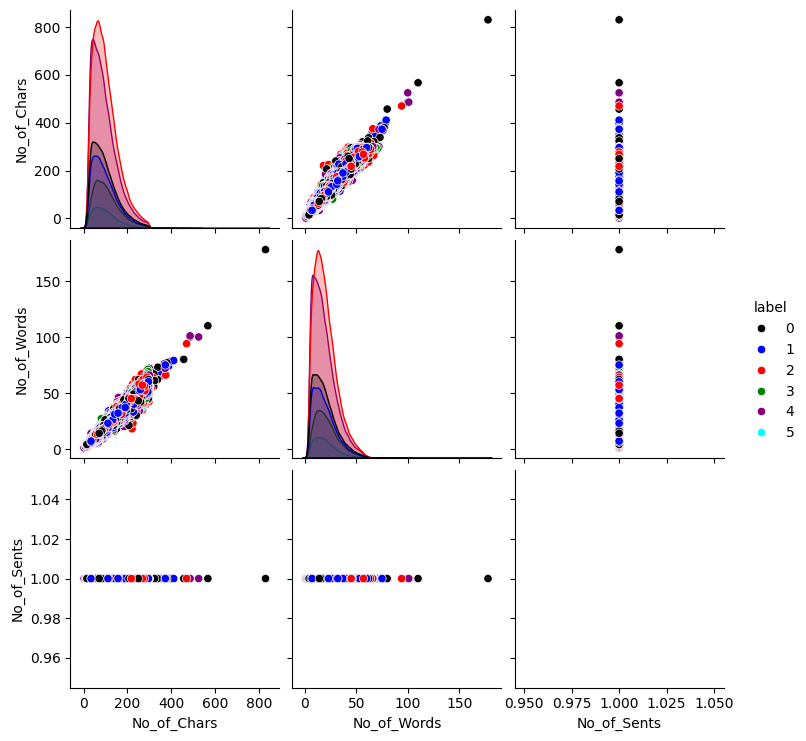

In [9]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data= data, hue= 'label', palette= cols_color)
plt.show(fg)

In [10]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [11]:
from nltk.corpus import wordnet

def get_wordnet_pos(tag):
    """
    تحويل POS tag من شكل NLTK إلى الشكل المطلوب من WordNetLemmatizer.
    """
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # الافتراضي




In [12]:
def preprocess_text(text: str) -> str:
    """
    تنظيف النص مع تحسين lemmatization باستخدام POS tagging.
    """
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    lemmatized_words = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in pos_tags
        if word not in stop_words
    ]
    return ' '.join(lemmatized_words)

data['lemmatized_words'] = data['text'].apply(preprocess_text)

C:\Users\Elgabrey\AppData\Local\Temp\ipykernel_23504\575512067.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fg = sns.countplot(x= data['label'], palette= cols_color)


Text(0, 0.5, 'count of classes')

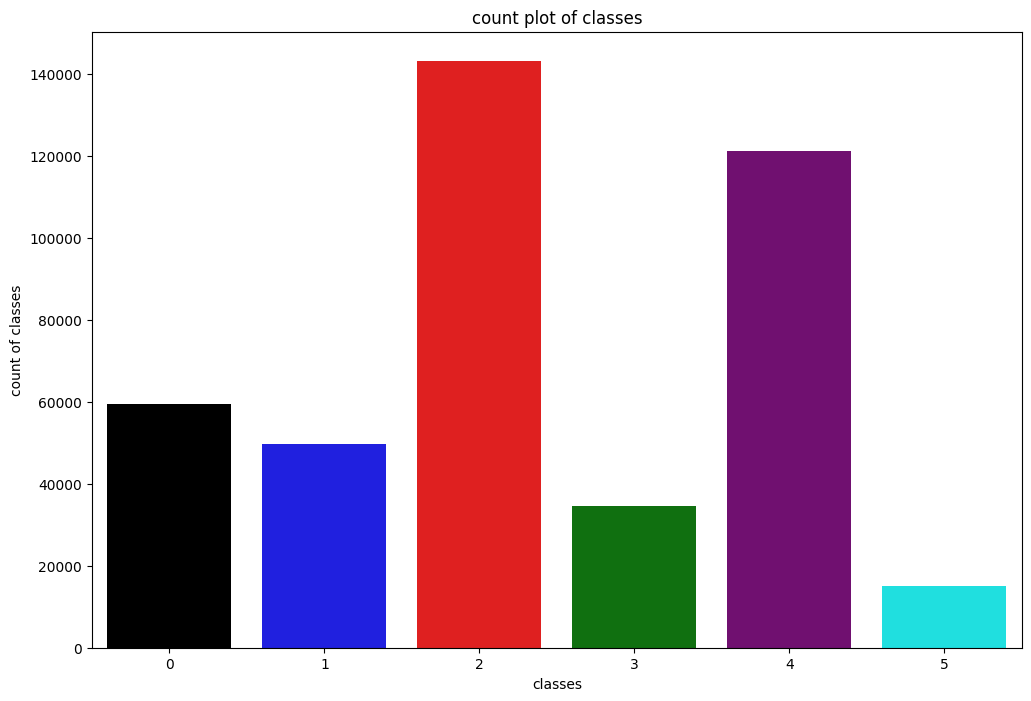

In [13]:
cols_color = ['black', 'blue', 'red', 'green', 'purple', 'cyan']
plt.figure(figsize=(12,8))
fg = sns.countplot(x= data['label'], palette= cols_color)
fg.set_title('count plot of classes')
fg.set_xlabel('classes')
fg.set_ylabel('count of classes')

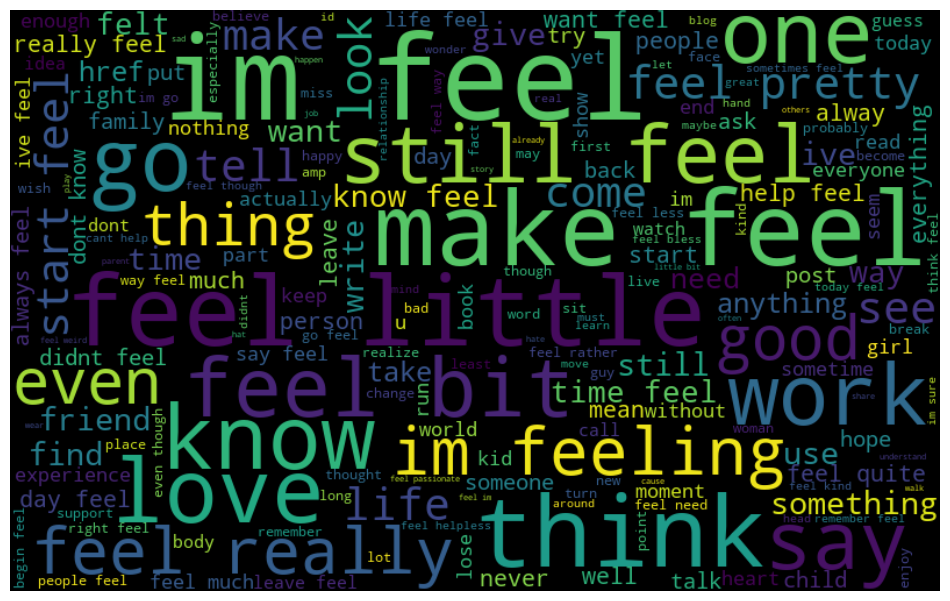

In [14]:
all_words = " ".join(sentence for sentence in data['lemmatized_words'])
all_words

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [15]:
tfidf = TfidfVectorizer(max_features=1000, max_df=0.9, min_df=2, stop_words='english', ngram_range=(1, 2))
sia = SentimentIntensityAnalyzer()

def vectorize_text(df: pd.DataFrame, text_col: str, vectorizer: TfidfVectorizer):
    """
    Vectorize text column using TF-IDF.

    Args:
        df (pd.DataFrame): Dataframe containing text data.
        text_col (str): Name of the column with preprocessed text.
        vectorizer (TfidfVectorizer): Initialized vectorizer.

    Returns:
        sparse matrix: TF-IDF features matrix.
    """
    X = vectorizer.fit_transform(df[text_col])
    return X

sampled_data = data.sample(frac=0.3, random_state=42)
X = vectorize_text(data, 'lemmatized_words', tfidf)
y = data['label']


In [63]:
def extract_additional_features(text: str) -> list:
    words = word_tokenize(text)
    num_words = len(words)
    num_chars = len(text)
    sentiment = sia.polarity_scores(text)['compound']
    readability = textstat.flesch_reading_ease(text)
    return [num_words, num_chars, sentiment, readability]

additional_features = np.array([extract_additional_features(text) for text in data['lemmatized_words']])
scaler = StandardScaler()
additional_features_scaled = scaler.fit_transform(additional_features)

In [64]:
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

X_combined = hstack([X, csr_matrix(additional_features_scaled)])


In [65]:
def extract_pos_tags(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    return ' '.join(tag for word, tag in pos_tags)

data['pos_tags'] = data['lemmatized_words'].apply(extract_pos_tags)

tfidf_pos = TfidfVectorizer()
X_pos = tfidf_pos.fit_transform(data['pos_tags'])
data['pos_tags']

0                                           NN RB JJ NN VBD
1         JJ NN JJ JJ NN IN JJ NN JJ NN RB VBP JJ NN RB ...
2                                            VB NN NN NN NN
3                                              NN VBP NN VB
4         VB PRP RB JJ NN VB NN NN NN NN NN NN VBP NN NN...
                                ...                        
422741                                            VB NNS JJ
422742                              VB NN IN JJ NN NN JJ NN
422743    RB VB JJ NN NN VBP VB RB VBP RB RB VBP JJ NN N...
422744                 NN JJ NN VBP JJ VBP NN VBP JJS CD NN
422745                                    JJ NN NN IN NN NN
Name: pos_tags, Length: 422746, dtype: object

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_balanced))


Before SMOTE: [ 47454  39719 114453  27643  96949  11978]
After SMOTE: [114453 114453 114453 114453 114453 114453]


In [67]:
from collections import Counter
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_balanced))


Before SMOTE: Counter({2: 114453, 4: 96949, 0: 47454, 1: 39719, 3: 27643, 5: 11978})
After SMOTE: Counter({4: 114453, 1: 114453, 2: 114453, 0: 114453, 3: 114453, 5: 114453})


In [68]:
row = X[0].toarray().flatten()
for i, val in enumerate(row):
    if val != 0:
        print(f'index {i}: {val}')


index 1207: 0.07476161722430262
index 1598: 0.3437060723516098
index 2207: 0.6096405621106891
index 2214: 0.5272353778464551
index 2228: 0.39970997625948496
index 3715: 0.2585923677793829


In [69]:
def train_and_evaluate(X_train, y_train, X_test, y_test):
    """
    Train Random Forest and evaluate on test set.

    Args:
        X_train, y_train: Training features and labels.
        X_test, y_test: Testing features and labels.

    Returns:
        model: Trained Random Forest model.
    """

    
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    
    """  param_grid = {
    'n_estimators': [100, 200, 300],           # عدد الأشجار
    'max_depth': [None, 10, 20, 30],           # أقصى عمق للشجرة
    'min_samples_split': [2, 5, 10]             # أقل عدد عينات لتقسيم عقدة
    } """
    """  
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,cv=3, n_jobs=-1, verbose=2, scoring='f1_weighted')
    grid_search.fit(X_train_balanced, y_train_balanced)
    
    print("أفضل المعاملات:", grid_search.best_params_)
    print("أفضل نتيجة F1 (weighted):", grid_search.best_score_)
    
    best_rf_model = grid_search.best_estimator_ """

    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Test set F1 Score (weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")
    print(classification_report(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    """ cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show() """
    
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
    return model

random_forest_model = train_and_evaluate(X_train_balanced, y_train_balanced, X_test, y_test)


Accuracy: 0.8290
Test set F1 Score (weighted): 0.8306
              precision    recall  f1-score   support

           0       0.84      0.87      0.86     11863
           1       0.78      0.81      0.80      9930
           2       0.86      0.85      0.86     28614
           3       0.63      0.69      0.66      6911
           4       0.90      0.85      0.88     24238
           5       0.59      0.70      0.64      2994

    accuracy                           0.83     84550
   macro avg       0.77      0.79      0.78     84550
weighted avg       0.83      0.83      0.83     84550

              precision    recall  f1-score   support

       anger       0.84      0.87      0.86     11863
        fear       0.78      0.81      0.80      9930
         joy       0.86      0.85      0.86     28614
        love       0.63      0.69      0.66      6911
         sad       0.90      0.85      0.88     24238
     suprise       0.59      0.70      0.64      2994

    accuracy           

comparison between models


In [ ]:
""" models = {
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"{name} F1 Score: {f1_score(y_test, y_pred, average='weighted'):.2f}")
    print("-" * 30)
 """

' models = {\n    \'Random Forest\': RandomForestClassifier(),\n    \'Naive Bayes\': MultinomialNB(),\n    \'SVM\': SVC(),\n    \'KNN\': KNeighborsClassifier()\n}\n\nfor name, model in models.items():\n    model.fit(X_train_balanced, y_train_balanced)\n    y_pred = model.predict(X_test)\n    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.2f}")\n    print(f"{name} F1 Score: {f1_score(y_test, y_pred, average=\'weighted\'):.2f}")\n    print("-" * 30)\n '

In [71]:
def predict_emotion(text, model, vectorizer, label_encoder, scaler):
    processed = preprocess_text(text)
    
    # تحويل النص إلى TF-IDF
    vect_text = vectorizer.transform([processed])
    
    # حساب الميزات الإضافية
    additional_feats = np.array([extract_additional_features(processed)])
    additional_feats_scaled = scaler.transform(additional_feats)
    
    # دمج الميزات
    from scipy.sparse import hstack, csr_matrix
    combined_features = hstack([vect_text, csr_matrix(additional_feats_scaled)])
    
    # التنبؤ
    prediction = model.predict(combined_features)
    return label_encoder.inverse_transform(prediction)[0]


# مثال تجربة
print(predict_emotion("I feel so happy and joyful today!", random_forest_model, tfidf, le, scaler))


joy


In [72]:
from collections import Counter
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_balanced))


Before SMOTE: Counter({2: 114453, 4: 96949, 0: 47454, 1: 39719, 3: 27643, 5: 11978})
After SMOTE: Counter({4: 114453, 1: 114453, 2: 114453, 0: 114453, 3: 114453, 5: 114453})


In [73]:
# تحميل قاعدة بيانات التوصية
books_db = pd.read_csv("books.csv", index_col='book_id')
books_db = books_db[['original_title', 'authors']]
books_db.rename(columns={'original_title': 'title'}, inplace=True)
books_db




,title,authors
book_id,,
2767052,The Hunger Games,Suzanne Collins
3,Harry Potter and the Philosopher's Stone,"J.K. Rowling, Mary GrandPré"
41865,Twilight,Stephenie Meyer
2657,To Kill a Mockingbird,Harper Lee
4671,The Great Gatsby,F. Scott Fitzgerald
...,...,...
7130616,Bayou Moon,Ilona Andrews
208324,Means of Ascent,Robert A. Caro
77431,The Mauritius Command,Patrick O'Brian


In [74]:
books_db.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 2767052 to 8914
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    9415 non-null   object
 1   authors  10000 non-null  object
dtypes: object(2)
memory usage: 234.4+ KB


In [75]:
books_db.dropna(inplace=True)

In [76]:
# تحميل داتاست المقالات
articles_db = pd.read_csv("articles.csv", index_col='id')  # يحتوي على title, link
articles_db


,url,title
id,,
1,https://towardsdatascience.com/not-all-rainbow...,Not All Rainbows and Sunshine: The Darker Side...
2,https://towardsdatascience.com/ethics-in-ai-po...,Ethics in AI: Potential Root Causes for Biased...
3,https://towardsdatascience.com/python-tuple-th...,"Python Tuple, The Whole Truth and Only the Tru..."
4,https://towardsdatascience.com/dates-and-subqu...,Dates and Subqueries in SQL
5,https://towardsdatascience.com/temporal-differ...,Temporal Differences with Python: First Sample...
...,...,...
2494,https://medium.com/swlh/brian-chesky-is-an-exa...,Brian Chesky is an Example of What it Means to...
2495,https://medium.com/swlh/5-red-flags-of-online-...,5 Red Flags of Online Business Gurus
2496,https://writingcooperative.com/recognizing-the...,Recognizing These Three Realities Can Help Set...


In [77]:
articles_db.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2498 entries, 1 to 2498
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     2498 non-null   object
 1   title   2498 non-null   object
dtypes: object(2)
memory usage: 58.5+ KB


In [78]:
# تحميل النموذج و TF-IDF
model = joblib.load("./models/random_forest_model.pkl")
vectorizer = joblib.load("./models/tfidf_vectorizer.pkl")

In [79]:
from scipy.sparse import hstack, csr_matrix
from typing import List
from sklearn.base import BaseEstimator

def classify_emotions(
    df: pd.DataFrame,
    text_column: str,
    model: BaseEstimator,
    vectorizer: TfidfVectorizer,
    scaler: StandardScaler,
    le: LabelEncoder,
    positive_emotions: List[str] = ["joy", "love", "surprise"],
    save_path: str = None
) -> pd.DataFrame:
    """
    يصنف المشاعر في عمود نصي ويُرجع فقط الصفوف ذات المشاعر الإيجابية.

    Args:
        df (pd.DataFrame): داتا فريم يحتوي على النصوص.
        text_column (str): اسم العمود الذي يحتوي على النصوص (مثل: "title" أو "book_title").
        model (BaseEstimator): نموذج تصنيف مدرب.
        vectorizer (TfidfVectorizer): محول TF-IDF.
        scaler (StandardScaler): مقياس الميزات الإضافية.
        le (LabelEncoder): مشفر العواطف.
        positive_emotions (List[str], optional): قائمة بالعواطف الإيجابية للاحتفاظ بها.
        save_path (str, optional): إذا تم توفيره، سيتم حفظ الداتا فريم النهائي في هذا المسار كملف CSV.

    Returns:
        pd.DataFrame: داتا فريم يحتوي على النصوص المصنفة ذات العواطف الإيجابية.
    """

    # تحقق من وجود العمود
    if text_column not in df.columns:
        raise ValueError(f"❌ العمود '{text_column}' غير موجود في الداتا فريم.")

    # تنظيف النصوص
    df['clean_text'] = df[text_column].apply(preprocess_text)

    # استخراج ميزات TF-IDF
    X_text = vectorizer.transform(df['clean_text'])

    # استخراج الميزات الإضافية
    additional_features = np.array([
        extract_additional_features(text) for text in df['clean_text']
    ])
    additional_scaled = scaler.transform(additional_features)

    # دمج الميزات
    combined_features = hstack([X_text, csr_matrix(additional_scaled)])

    # التنبؤ بالعاطفة
    predicted = model.predict(combined_features)
    df['emotion'] = le.inverse_transform(predicted)

    # الاحتفاظ فقط بالعواطف الإيجابية
    df_filtered = df[df['emotion'].isin(positive_emotions)]


    # حفظ إذا تم تحديد مسار
    if save_path:
        df_filtered.to_csv(save_path, index=False)

    return df_filtered


In [80]:
try:
    df_clean = classify_emotions(
        df=books_db,
        text_column="title",
        model=model,
        vectorizer=vectorizer,
        scaler=scaler,
        le=le,
        save_path="classified_books.csv"
    )
except ValueError as e:
    print(str(e))


In [81]:
try:
    df_clean = classify_emotions(
        df=articles_db,
        text_column="title",
        model=model,
        vectorizer=vectorizer,
        scaler=scaler,
        le=le,
        save_path="classified_articles.csv"
    )
except ValueError as e:
    print(str(e))


In [82]:
def filter_by_keywords(df: pd.DataFrame, include_keywords=None, exclude_keywords=None) -> pd.DataFrame:
    """
    ترشيح المحتوى بناءً على كلمات مفتاحية.
    
    Args:
        df (pd.DataFrame): جدول المحتوى.
        include_keywords (list): كلمات يجب أن يحتويها النص.
        exclude_keywords (list): كلمات يجب ألا يحتويها النص.
    
    Returns:
        pd.DataFrame: محتوى بعد التصفية.
    """
    if include_keywords:
        pattern = '|'.join(include_keywords)
        df = df[df['title'].str.contains(pattern, case=False, na=False)]
    
    if exclude_keywords:
        pattern = '|'.join(exclude_keywords)
        df = df[~df['title'].str.contains(pattern, case=False, na=False)]

    return df

In [83]:
mood_map = {
    'sadness': ['joy', 'surprise'],
    'anger': ['love', 'joy'],
    'fear': ['love', 'joy'],
    'joy': ['joy','surprise', 'love'],
    'surprise': ['love', 'joy'],
    'love': ['joy', 'love', 'surprise']
    }

In [ ]:

def recommend_content_filtered(
    user_text: str,
    model,
    vectorizer,
    label_encoder,
    rec_db: pd.DataFrame,
    include_keywords=None,
    exclude_keywords=None
) -> pd.DataFrame:
    """
    #توصية بمحتوى مع فلترة اختيارية بناءً على الكلمات المفتاحية.
    """
    # تنظيف أسماء الأعمدة من المسافات الزائدة
    rec_db.columns = rec_db.columns.str.strip()

    # التأكد من وجود الأعمدة المطلوبة
    if 'predicted_emotion' not in rec_db.columns or 'original_title' not in rec_db.columns:
        raise KeyError("⚠️ تأكد أن الداتا تحتوي على الأعمدة: 'original_title' و 'predicted_emotion'.")

    # التنبؤ بالمشاعر للنص
    user_emotion = predict_emotion(user_text, model, vectorizer, label_encoder)
    print(f"🔍 Detected Emotion: {user_emotion}")

    # تحديد المشاعر المستهدفة بناءً على mood_map
    target_emotions = mood_map.get(user_emotion, ['joy', 'calm', 'confidence'])

    # ترشيح المحتوى بناءً على المشاعر
    recommended = rec_db[rec_db['predicted_emotion'].isin(target_emotions)]

    # فلترة المحتوى بناءً على الكلمات
    filtered = filter_by_keywords(recommended, include_keywords, exclude_keywords)

    # في حالة عدم وجود نتائج بعد الفلترة
    if filtered.empty:
        print("⚠️ لا يوجد محتوى يلبي معايير الفلترة. عرض نتائج بدون فلترة.")
        return recommended[['original_title', 'authors','predicted_emotion']].sample(min(3, len(recommended)))

    return filtered[['original_title', 'authors', 'predicted_emotion']].sample(min(3, len(filtered)))



'\n    # تنظيف أسماء الأعمدة من المسافات الزائدة\n    rec_db.columns = rec_db.columns.str.strip()\n\n    # التأكد من وجود الأعمدة المطلوبة\n    if \'predicted_emotion\' not in rec_db.columns or \'original_title\' not in rec_db.columns:\n        raise KeyError("⚠️ تأكد أن الداتا تحتوي على الأعمدة: \'original_title\' و \'predicted_emotion\'.")\n\n    # التنبؤ بالمشاعر للنص\n    user_emotion = predict_emotion(user_text, model, vectorizer, label_encoder)\n    print(f"🔍 Detected Emotion: {user_emotion}")\n\n    # تحديد المشاعر المستهدفة بناءً على mood_map\n    target_emotions = mood_map.get(user_emotion, [\'joy\', \'calm\', \'confidence\'])\n\n    # ترشيح المحتوى بناءً على المشاعر\n    recommended = rec_db[rec_db[\'predicted_emotion\'].isin(target_emotions)]\n\n    # فلترة المحتوى بناءً على الكلمات\n    filtered = filter_by_keywords(recommended, include_keywords, exclude_keywords)\n\n    # في حالة عدم وجود نتائج بعد الفلترة\n    if filtered.empty:\n        print("⚠️ لا يوجد محتوى يلبي معايي

In [84]:
def recommend_books(emotion: str, top_n: int = 5) -> List[Dict]:
    df = pd.read_csv("classified_books.csv")  # يحتوي على title, link

    # تصنيف المقالات إذا لسه ما اتصنفتش
    if "emotion" not in df.columns:
        df["emotion"] = df["title"].apply(predict_emotion)

    # حدد المشاعر اللي ممكن تحسن المزاج
    target_emotions = mood_map.get(emotion, ["joy", "love", "surprise"])

    # رشّح المقالات اللي مشاعرها إيجابية ومناسبة لتحسين المزاج
    recommended = df[df["emotion"].isin(target_emotions)].head(top_n)

    return recommended[["title", "authors", "emotion"]].to_dict(orient="records")


In [85]:
def recommend_articles(emotion: str, top_n: int = 5) -> List[Dict]:
    df = pd.read_csv("classified_articles.csv")  # يحتوي على title, link

    # تصنيف المقالات إذا لسه ما اتصنفتش
    if "emotion" not in df.columns:
        df["emotion"] = df["title"].apply(predict_emotion)

    # حدد المشاعر اللي ممكن تحسن المزاج
    target_emotions = mood_map.get(emotion, ["joy", "love", "surprise"])

    # رشّح المقالات اللي مشاعرها إيجابية ومناسبة لتحسين المزاج
    recommended = df[df["emotion"].isin(target_emotions)].head(top_n)

    return recommended[["title", "url", "emotion"]].to_dict(orient="records")


In [86]:
def recommend_content(emotion: str, top_n: int = 5) -> Dict[str, List[Dict]]:
    books = recommend_books(emotion)[:top_n]
    articles = recommend_articles(emotion)[:top_n]
    return {
        "books": books,
        "articles": articles
    }


In [87]:
results = recommend_content(emotion="sad")

print("Books:")
for item in results.get('books', []):
    print(f"- Title: {item.get('title')}, Authors: {item.get('authors')}, Emotion: {item.get('emotion')}")

print("\nArticles:")
for item in results.get('articles', []):
    print(f"- Title: {item.get('title')}, Link: {item.get('link')}, Emotion: {item.get('emotion')}")


Books:
- Title: Harry Potter and the Philosopher's Stone, Authors: J.K. Rowling, Mary GrandPré, Emotion: joy
- Title: The Great Gatsby, Authors: F. Scott Fitzgerald, Emotion: joy
- Title: Angels & Demons , Authors: Dan Brown, Emotion: joy
- Title: Animal Farm: A Fairy Story, Authors: George Orwell, Emotion: joy
- Title: Harry Potter and the Order of the Phoenix, Authors: J.K. Rowling, Mary GrandPré, Emotion: joy

Articles:
- Title: Not All Rainbows and Sunshine: The Darker Side of ChatGPT, Link: None, Emotion: joy
- Title: Python Tuple, The Whole Truth and Only the Truth: Let’s Dig Deep, Link: None, Emotion: joy
- Title: 10 Subtle Strategies I Wish I Knew When I Had 23 Email Subscribers and Made $0 Online, Link: None, Emotion: joy
- Title: Don’t Become a Full-Time Content Creator If You Have Low-Risk Tolerance, Link: None, Emotion: joy
- Title: Why My Side Hustle Stuck After 3 Years and What I Want to Do to Improve It, Link: None, Emotion: joy


In [88]:
results = recommend_books(emotion="sad")
for book in results:
    print(book)

{'title': "Harry Potter and the Philosopher's Stone", 'authors': 'J.K. Rowling, Mary GrandPré', 'emotion': 'joy'}
{'title': 'The Great Gatsby', 'authors': 'F. Scott Fitzgerald', 'emotion': 'joy'}
{'title': 'Angels & Demons ', 'authors': 'Dan Brown', 'emotion': 'joy'}
{'title': 'Animal Farm: A Fairy Story', 'authors': 'George Orwell', 'emotion': 'joy'}
{'title': 'Harry Potter and the Order of the Phoenix', 'authors': 'J.K. Rowling, Mary GrandPré', 'emotion': 'joy'}


In [89]:
results = recommend_articles(emotion="sad")
for article in results:
    print(article)


{'title': 'Not All Rainbows and Sunshine: The Darker Side of\xa0ChatGPT', 'url': 'https://towardsdatascience.com/not-all-rainbows-and-sunshine-the-darker-side-of-chatgpt-75917472b9c', 'emotion': 'joy'}
{'title': 'Python Tuple, The Whole Truth and Only the Truth: Let’s Dig\xa0Deep', 'url': 'https://towardsdatascience.com/python-tuple-the-whole-truth-and-only-truth-lets-dig-deep-24d2bf02971b', 'emotion': 'joy'}
{'title': '10 Subtle Strategies I Wish I Knew When I Had 23 Email Subscribers and Made $0\xa0Online', 'url': 'https://medium.com/swlh/10-subtle-strategies-i-wish-i-knew-when-i-had-23-email-subscribers-and-made-0-online-3eb65c335060', 'emotion': 'joy'}
{'title': 'Don’t Become a Full-Time Content Creator If You Have Low-Risk Tolerance', 'url': 'https://medium.com/swlh/dont-become-a-full-time-content-creator-if-you-have-low-risk-tolerance-13fa2f77791a', 'emotion': 'joy'}
{'title': 'Why My Side Hustle Stuck After 3 Years and What I Want to Do to Improve\xa0It', 'url': 'https://medium.

In [ ]:
""" import joblib

joblib.dump(random_forest_model, './models/random_forest_model.pkl')
joblib.dump(tfidf, './models/tfidf_vectorizer.pkl')
joblib.dump(le, './models/label_encoder.pkl')
joblib.dump(scaler, './models/scaler.pkl') """


['./models/tfidf_vectorizer.pkl']